# Momentum Trading Strategy

#### Importing Libraries



In [13]:
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import yfinance as yf

In [14]:
gld = yf.download('GLD')
gld = gld.copy()
day = np.arange(1, len(gld) + 1)
gld['day'] = day
gld.drop(columns=['Adj Close', 'Volume'], inplace = True)
gld = gld[['day', 'Open', 'High', 'Low', 'Close']]
gld.head()

[*********************100%%**********************]  1 of 1 completed


,day,Open,High,Low,Close
Date,,,,,
2004-11-18,1,44.430000,44.490002,44.070000,44.380001
2004-11-19,2,44.490002,44.919998,44.470001,44.779999
2004-11-22,3,44.750000,44.970001,44.740002,44.950001
2004-11-23,4,44.880001,44.919998,44.720001,44.750000
2004-11-24,5,44.930000,45.049999,44.790001,45.049999


In [15]:
gld.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4939 entries, 2004-11-18 to 2024-07-05
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   day     4939 non-null   int64  
 1   Open    4939 non-null   float64
 2   High    4939 non-null   float64
 3   Low     4939 non-null   float64
 4   Close   4939 non-null   float64
dtypes: float64(4), int64(1)
memory usage: 231.5 KB


### Adding Moving Averages to Data Frame

In [16]:
gld.loc[:, '9-day'] = gld['Close'].rolling(9).mean().shift()
gld.loc[:, '21-day'] = gld['Close'].rolling(21).mean().shift()
gld[19:25]

,day,Open,High,Low,Close,9-day,21-day
Date,,,,,,,
2004-12-16,20,43.990002,44.049999,43.580002,43.680000,44.284444,NaN
2004-12-17,21,43.930000,44.220001,43.779999,44.189999,44.071111,NaN
2004-12-20,22,44.330002,44.369999,44.130001,44.340000,43.962222,44.594286
2004-12-21,23,44.130001,44.240002,44.049999,44.220001,43.876666,44.592381
2004-12-22,24,44.200001,44.230000,43.889999,44.020000,43.900000,44.565714
2004-12-23,25,44.169998,44.349998,44.049999,44.270000,43.926667,44.521428


### Adding Signal Column

In [17]:
gld.loc[:, 'signal'] = np.where(gld['9-day'] > gld['21-day'], 1, 0)
gld.loc[:, 'signal'] = np.where(gld['9-day'] < gld['21-day'], -1, gld['signal'])
gld.dropna(inplace=True)
gld.head()

,day,Open,High,Low,Close,9-day,21-day,signal
Date,,,,,,,,
2004-12-20,22,44.330002,44.369999,44.130001,44.340000,43.962222,44.594286,-1
2004-12-21,23,44.130001,44.240002,44.049999,44.220001,43.876666,44.592381,-1
2004-12-22,24,44.200001,44.230000,43.889999,44.020000,43.900000,44.565714,-1
2004-12-23,25,44.169998,44.349998,44.049999,44.270000,43.926667,44.521428,-1
2004-12-27,26,44.290001,44.560001,44.270000,44.480000,44.018889,44.498571,-1


### Instantaneous Returns/System Returns

In [19]:
gld['return'] = np.log(gld['Close']).diff()
gld['system_return'] = gld['signal']*gld['return']
gld['entry'] = gld.signal.diff()
gld.head()

,day,Open,High,Low,Close,9-day,21-day,signal,return,system_return,entry
Date,,,,,,,,,,,
2004-12-20,22,44.330002,44.369999,44.130001,44.340000,43.962222,44.594286,-1,NaN,NaN,NaN
2004-12-21,23,44.130001,44.240002,44.049999,44.220001,43.876666,44.592381,-1,-0.002710,0.002710,0.0
2004-12-22,24,44.200001,44.230000,43.889999,44.020000,43.900000,44.565714,-1,-0.004533,0.004533,0.0
2004-12-23,25,44.169998,44.349998,44.049999,44.270000,43.926667,44.521428,-1,0.005663,-0.005663,0.0
2004-12-27,26,44.290001,44.560001,44.270000,44.480000,44.018889,44.498571,-1,0.004732,-0.004732,0.0


### Plotting Trades on a time series

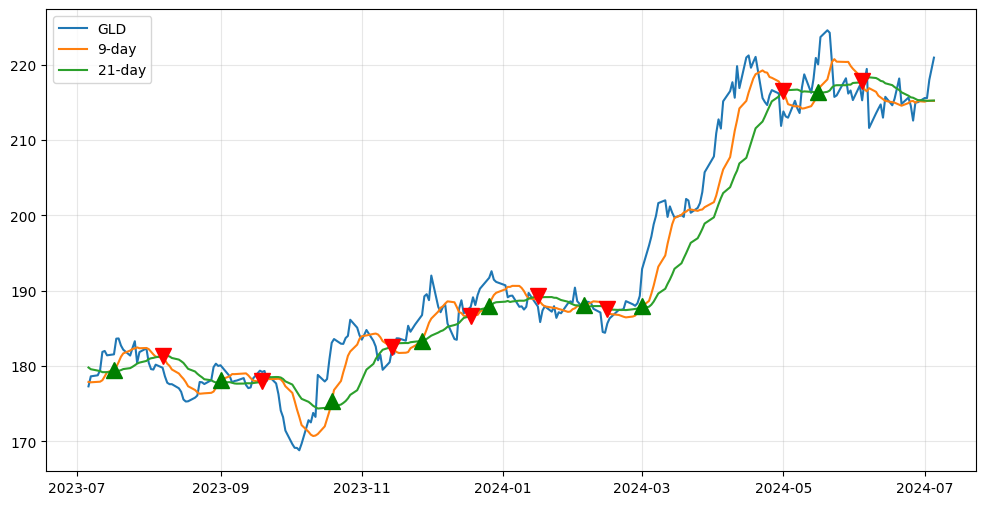

In [26]:
plt.rcParams['figure.figsize'] = 12, 6
plt.grid(True, alpha = .3)
plt.plot(gld.iloc[-252:]['Close'], label = 'GLD')
plt.plot(gld.iloc[-252:]['9-day'], label = '9-day')
plt.plot(gld.iloc[-252:]['21-day'], label = '21-day')
plt.plot(gld[-252:].loc[gld.entry == 2].index, gld[-252:]['9-day'][gld.entry == 2], '^',
         color = 'g', markersize = 12)
plt.plot(gld[-252:].loc[gld.entry == -2].index, gld[-252:]['21-day'][gld.entry == -2], 'v',
         color = 'r', markersize = 12)
plt.legend(loc=2);

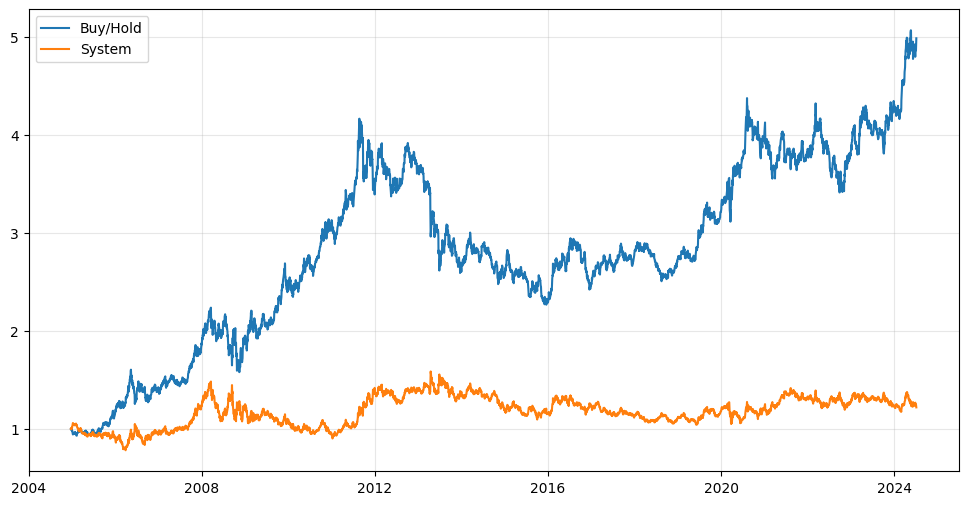

In [27]:
plt.plot(np.exp(gld['return']).cumprod(), label='Buy/Hold')
plt.plot(np.exp(gld['system_return']).cumprod(), label='System')
plt.legend(loc=2)
plt.grid(True, alpha=.3)

### Overall Returns

In [30]:
buy_hold_return = np.exp(gld['return']).cumprod().iloc[-1] - 1
print(buy_hold_return)

3.982634008017408


In [31]:
system_return = np.exp(gld['system_return']).cumprod().iloc[-1] - 1
print(system_return)

0.21953715947147412
